In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
from pipeline import SD3JediPipeline
from utils import print_token_correspondences, JEDI

In [2]:
pipe = SD3JediPipeline.from_pretrained(
    "stabilityai/stable-diffusion-3.5-medium", 
    torch_dtype=torch.float16
)

pipe.enable_sequential_cpu_offload()

# Disable gradients for all parameters
pipe.transformer.requires_grad_(False)
pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)
pipe.text_encoder_2.requires_grad_(False)
pipe.text_encoder_3.requires_grad_(False)
print("Model loaded")

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded


In [3]:
PROMPT = "A horse and a bear in a forest"

print_token_correspondences(pipe, PROMPT)

Prompt: A horse and a bear in a forest
+---------+---------+-----------------+-----------------+
|   Index | T5      | CLIP-G          | CLIP-L          |
+=========+=========+=================+=================+
|       0 | ▁A      | <|startoftext|> | <|startoftext|> |
+---------+---------+-----------------+-----------------+
|       1 | ▁horse  | a</w>           | a</w>           |
+---------+---------+-----------------+-----------------+
|       2 | ▁and    | horse</w>       | horse</w>       |
+---------+---------+-----------------+-----------------+
|       3 | ▁       | and</w>         | and</w>         |
+---------+---------+-----------------+-----------------+
|       4 | a       | a</w>           | a</w>           |
+---------+---------+-----------------+-----------------+
|       5 | ▁bear   | bear</w>        | bear</w>        |
+---------+---------+-----------------+-----------------+
|       6 | ▁in     | in</w>          | in</w>          |
+---------+---------+------------

  0%|          | 0/28 [00:00<?, ?it/s]

Loss: 0.917 ± 0.06	Intra-group Coherence: 0.032	Iner-group Seperation: 0.884	Diversity Regularization: 0.110
Loss: 0.863 ± 0.09	Intra-group Coherence: 0.029	Iner-group Seperation: 0.833	Diversity Regularization: 0.106
Loss: 0.925 ± 0.04	Intra-group Coherence: 0.034	Iner-group Seperation: 0.891	Diversity Regularization: 0.111
Loss: 0.912 ± 0.05	Intra-group Coherence: 0.036	Iner-group Seperation: 0.874	Diversity Regularization: 0.131
Loss: 0.889 ± 0.08	Intra-group Coherence: 0.037	Iner-group Seperation: 0.851	Diversity Regularization: 0.146
Loss: 0.768 ± 0.18	Intra-group Coherence: 0.038	Iner-group Seperation: 0.728	Diversity Regularization: 0.176
Loss: 0.631 ± 0.25	Intra-group Coherence: 0.064	Iner-group Seperation: 0.565	Diversity Regularization: 0.212
Loss: 0.585 ± 0.26	Intra-group Coherence: 0.073	Iner-group Seperation: 0.509	Diversity Regularization: 0.240
Loss: 0.581 ± 0.26	Intra-group Coherence: 0.094	Iner-group Seperation: 0.485	Diversity Regularization: 0.250
Loss: 0.581 ± 0.26	

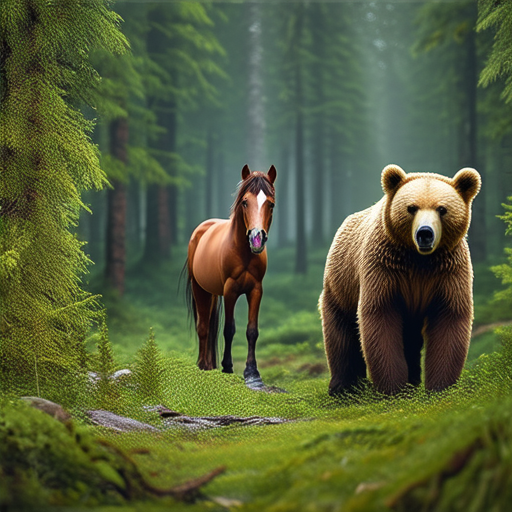

In [4]:
SEED = 0

jedi = JEDI(
    t5_ids = [[1], [5]], # <- Put the T5 tokens ids here, where each subgroup defines a subject group
    clip_ids = [[2], [5]], # <- Put the CLIP token ids here, where each subgroup defines a subject group
)

output_jedi = pipe(
    PROMPT,
    num_inference_steps=28,
    guidance_scale=4.5,
    height=512,
    width=512,
    max_sequence_length=77,
    generator=torch.Generator("cuda").manual_seed(SEED),
    jedi=jedi,
)

output_jedi.images[0]

  0%|          | 0/28 [00:00<?, ?it/s]

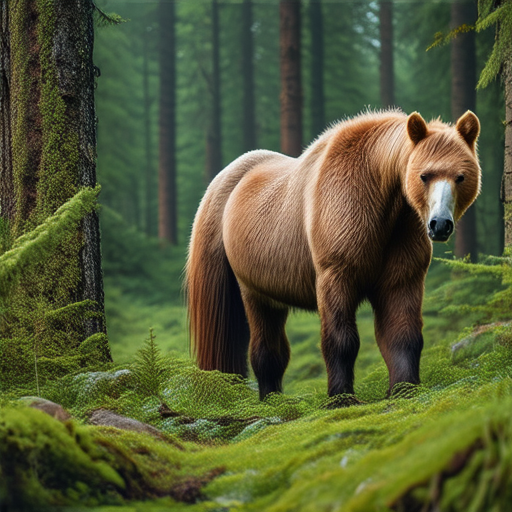

In [5]:
SEED = 0

# To deactivate JEDI, set jedi to None or set the learning rate to 0.0
jedi.lr = 0.0

output_base = pipe(
    PROMPT,
    num_inference_steps=28,
    guidance_scale=4.5,
    height=512,
    width=512,
    max_sequence_length=77,
    generator=torch.Generator("cuda").manual_seed(SEED),
    jedi=jedi,
)

output_base.images[0]